# Analysing AirBnB Data : Boston and Seattle #

## Methodologies : CRISP-DM  ##

CRISP-DM standards for Cross-Industry Standard Process for Data Mining and the whole includes 6 steps - business understanding, data understanding, data preparation, modeling, evaluation, and deployment. 

**Business Understanding**: From the datasets we can get a better understanding how we can set the rental price for peroperties and figure out some interesting differences between Boston and Seattle Airbnb. Three business aspect questions were asked before diving into the dataset:  
1. What are observable difference between Seattle and Boston Airbnb?  
2. What are the most important features which can help estimating Airbnb rentals?  
3. What are the top most needed fecilities ?  

**Data**：
- Boston dataset consists of around 5764 listings including full descriptions and average review score
- Seattle's has around 8377 listings including full descriptions and average review score

**Data Preparation**: 
- Including data cleaning 
- Filling NAN value
- One-hot encoding  
- MinMax preprocessing 

**Data Modeling**: 
- Used GridSearch with 5 folds validation to find best parameter for GradientBoostingRegressor. 

**Evaluate the Results**: for results and discussion visit https://medium.com/@chintu5384/analysing-airbnb-data-boston-and-seattle-edc1913f8318

In [1]:
#lets inport libraries here...
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#lets inport data here...
listings_Boston_df = pd.read_csv("listings_Boston.csv")
listings_Seattle_df = pd.read_csv("listings_Seattle.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Lets review shapes of data we have
print("Boston data shape", listings_Boston_df.shape)
print("Seatlle data shape", listings_Seattle_df.shape)

Boston data shape (6036, 96)
Seatlle data shape (8494, 96)


In [4]:
#lets review the data for Boston
listings_Boston_df.head()
#lets review the data for Seattle
listings_Seattle_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20180816121209,2018-08-16,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,...,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16
1,4291,https://www.airbnb.com/rooms/4291,20180816121209,2018-08-16,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,...,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.91
2,5682,https://www.airbnb.com/rooms/5682,20180816121209,2018-08-16,"Cozy Studio, min. to downtown -WiFi",The Cozy Studio is a perfect launchpad for you...,"Hello fellow travelers, Save some money and ha...",The Cozy Studio is a perfect launchpad for you...,none,NaN,...,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,t,1,4.38
3,6606,https://www.airbnb.com/rooms/6606,20180816121209,2018-08-16,"Fab, private seattle urban cottage!",NaN,"Soo centrally located, this is a little house ...","Soo centrally located, this is a little house ...",none,"A peaceful yet highly accessible neighborhood,...",...,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,f,3,1.12
4,9419,https://www.airbnb.com/rooms/9419,20180816121209,2018-08-16,Glorious sun room w/ memory foambed,This beautiful double room features a magical ...,Our new Sunny space has a private room from th...,This beautiful double room features a magical ...,none,"Lots of restaurants (see our guide book) bars,...",...,f,NaN,{WASHINGTON},f,f,moderate,t,t,5,1.29


## Preprocessing the data ##

In [5]:
def preprocessing(listings):
    '''
    input:
        listings: listings dataset of target city.
    output:
        processed_listings_df: The preprocessed (Cleaning, Filling Missing data, One-hot encoding, MinMax transform...) listings.
        price_raw: Split from original listings and serve as target in training process.
        possible_fecility: Return all fecility listed by Airbnb host in certain city.
    '''

    # Plot the Ratio of missing data for all Column
    null_list = listings.isnull().sum()
    null_per = null_list / len(listings) * 100
    
    '''
    plt.figure(figsize=(20,5))
    plt.title('Distribution of the Ratio of Missing Data in Each Column')
    plt.hist(null_per, bins = np.linspace(10,100,50))
    plt.xlabel('Percentage of Missing Data')
    plt.ylabel('Count')
    plt.show()
    '''
    
    # Drop part of the columns with high ratio of missing data
    drop_index = null_per[null_per > 50].index
    listings.drop(drop_index, axis = 1, inplace = True)
    
    # Preprocess 'price' columns into numerical value
    if type(listings.price[0]) == str:
        listings.price = listings.price.apply(lambda x: float(x[1:].replace(',', '')))
    print(listings.price.describe())
    
    # Plot the distribution of price in Certain City
    plt.figure(figsize=(15,4))
    plt.title('Price Distribution')
    plt.hist(listings.price,bins = np.linspace(0, 1000, 100))
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.show()
    
    # Drop high price rows and some other non meaningful columns
    drop_price_index = listings[listings.price > 500].index
    listings.drop(drop_price_index, axis = 0, inplace = True)
    listings.drop(['space', 'neighborhood_overview', 'notes', 'transit', 
                   'access', 'interaction', 'house_rules','listing_url', 
                   'scrape_id', 'last_scraped', 'name', 'summary', 
                   'description', 'experiences_offered', 'picture_url', 
                   'host_url', 'host_name', 'host_thumbnail_url', 'host_about', 
                   'host_neighbourhood', 'host_picture_url', 'host_location', 
                   'street', 'city', 'state', 'smart_location', 'country_code', 'country', 
                   'first_review', 'last_review', 'id', 'host_verifications', 'host_id',
                   'neighbourhood', 'calendar_last_scraped', 'market'], axis = 1, inplace = True)
    
    # Preprocess the 'host_since' column
    now = datetime.strptime('2018-11-18','%Y-%m-%d')
    listings.host_since = listings.host_since.apply(lambda x: (now - datetime.strptime(x, '%Y-%m-%d')).days)
    
    # Take care of 'fecilities' column (transfer into catagorical column)
    df = listings
    
    fecilities = df['amenities'].map(lambda d: [fecility.replace("{", "").replace("}", "").replace('"', "") for fecility in d.split(",")])
    df['amenities'] = fecilities
    
    possible_fecilities = set([item for sublist in fecilities for item in sublist])
    possible_fecilities = list(possible_fecilities)
    
    del possible_fecilities[1]
    print("There are total {} fecilities available.".format(len(possible_fecilities)))
    
    mlb = MultiLabelBinarizer()
    fecilities_result = pd.DataFrame(mlb.fit_transform(df['amenities']),columns=mlb.classes_, index=df.index)
    processed_listings_df = pd.concat([df, fecilities_result], axis=1, sort = False)
    processed_listings_df.drop(['amenities'], axis = 1, inplace = True)
    
    # Preprocess some other columns, convert into numerical value
    processed_listings_df['cleaning_fee'] = processed_listings_df['cleaning_fee'].replace( '[$,]','', regex=True ).astype(float)
    processed_listings_df['extra_people'] = processed_listings_df['extra_people'].replace( '[$,]','', regex=True ).astype(float)
    processed_listings_df['security_deposit'] = processed_listings_df['security_deposit'].replace( '[$,]','', regex=True ).astype(float)
    processed_listings_df['host_response_rate'] = processed_listings_df['host_response_rate'].replace( '%','', regex=True ).astype(float)
    if type(processed_listings_df.zipcode[0]) == str:
        processed_listings_df.zipcode = processed_listings_df.zipcode.str[:5].apply(lambda x: float(x))
    
    # Fill missing data - we will generate missing nans
    processed_listings_df.bathrooms.fillna(processed_listings_df.groupby("bedrooms")["bathrooms"].transform("median"), inplace=True)
    processed_listings_df.beds.fillna(processed_listings_df.groupby("bedrooms")["beds"].transform("median"), inplace=True)
    processed_listings_df.bedrooms.fillna(processed_listings_df.groupby("bathrooms")["bedrooms"].transform("median"), inplace=True)
    processed_listings_df.security_deposit.fillna(0, inplace = True)
    processed_listings_df.cleaning_fee.fillna(0, inplace = True)
    fillmean_list = ['review_scores_rating', 'review_scores_accuracy', 
                     'review_scores_cleanliness', 'review_scores_checkin', 
                     'review_scores_communication', 'review_scores_location', 
                     'review_scores_value', 'reviews_per_month']
    
    for col in fillmean_list:
        processed_listings_df[col].fillna(df[col].mean(), inplace = True)
    processed_listings_df['host_response_rate'].fillna(processed_listings_df.host_response_rate.mean(), inplace = True)   
    processed_listings_df.zipcode.fillna(listings_Boston_df.groupby('neighbourhood_cleansed')['zipcode'].apply(lambda x: x.fillna(x.value_counts().index[0])), inplace = True)
    
    # One-hot encoding the whole dataframe
    processed_listings_df = pd.get_dummies(processed_listings_df)
    price_raw = processed_listings_df['price']
    processed_listings_df = processed_listings_df.drop('price', axis = 1)
    
    # Use MinMax to process some of the numerical data
    scaler = MinMaxScaler()
    numerical = ['host_since', 'latitude', 'longitude', 'review_scores_rating']
    processed_listings_df[numerical] = scaler.fit_transform(processed_listings_df[numerical])
    return processed_listings_df, price_raw, possible_fecilities

## Traning the model ##

In [6]:
def training(processed_listings_df, price_raw, possible_fecilities):
    '''
    input:
        processed_listings_df: The preprocessed (Cleaning, Filling Missing data, One-hot encoding, MinMax transform...) listings.
        price_raw: Split from original listings and serve as target in training process.
        possible_fecilities: Return all fecilities listed by Airbnb host in certain city.
    output:
        None
    '''
    
    
    # Split the preprocessed dataset into train/test dataset
    X_train, X_test, y_train, y_test = train_test_split(processed_listings_df, price_raw, test_size = 0.2, random_state = 0)
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    
    # Grid Search to find Best Parameter
    param_grid = {'n_estimators': [400], 
                  'learning_rate': [0.05],
                  'max_depth': [10],
                  'min_samples_split': [5],
                  'subsample': [0.7]
                 }

    forest_reg = GradientBoostingRegressor(random_state = 42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
    y_pred = grid_search.predict(X_test)
    print("Error Score on Test Data: {}.".format(np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))))
    
    # Plot feature importance for the Top 20 features
    feature_importances = grid_search.best_estimator_.feature_importances_
    features = sorted(zip(feature_importances, processed_listings_df.columns), reverse=True)
    attribute = []
    coefficient = []
    for feature in features:
        attribute.append(feature[1]) 
        coefficient.append(feature[0])
    plt.figure(figsize=(15,4))
    plt.bar(attribute[:20], height=coefficient[:20])
    plt.xticks(rotation=90)
    plt.xlabel('feature')
    plt.ylabel('feature importance')
    plt.title('feature importance for the Top 20 features')
    plt.show()
    
    # Plot feature importance for the Top 10 fecilities
    fecility= []
    amn_coef = []
    for feature in features:
        if feature[1] in possible_fecilities:
            fecility.append(feature[1])
            amn_coef.append(feature[0])
    plt.figure(figsize=(15,4))
    plt.bar(fecility[:10], height=amn_coef[:10])
    plt.xticks(rotation = 90)
    plt.xlabel('fecility')
    plt.ylabel('fecility importance')
    plt.title('feature importance for the Top 10 fecilities')
    plt.show()

count    6036.000000
mean      184.089629
std       184.401721
min         0.000000
25%        80.000000
50%       140.000000
75%       219.000000
max      3999.000000
Name: price, dtype: float64


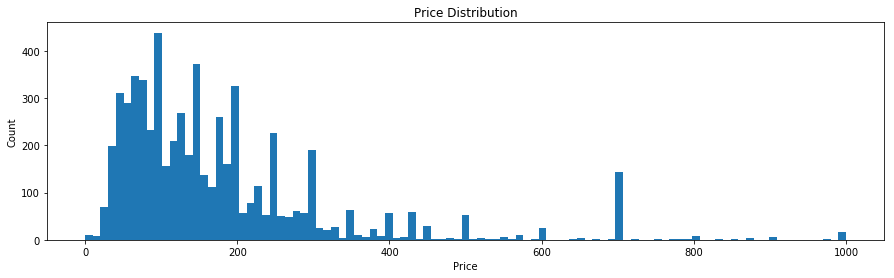

There are total 120 fecilities available.
count    8494.000000
mean      152.532494
std       137.133373
min         0.000000
25%        80.000000
50%       119.000000
75%       189.000000
max      5400.000000
Name: price, dtype: float64


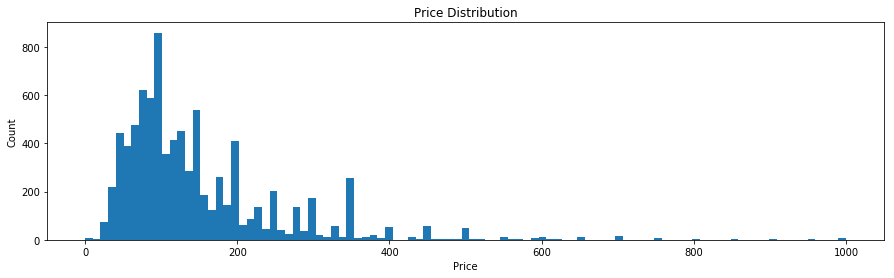

There are total 168 fecilities available.


In [7]:
#preprocessing boston data
Boston, price_Boston, possible_fecilities_Boston = preprocessing(listings_Boston_df)
#preprocessing seattle data
Seattle, price_Seattle, possible_fecilities_Seattle = preprocessing(listings_Seattle_df)

Training set has 4611 samples.
Testing set has 1153 samples.
{'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
51.309006535977964 {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
Error Score on Test Data: 48.78591829441084.


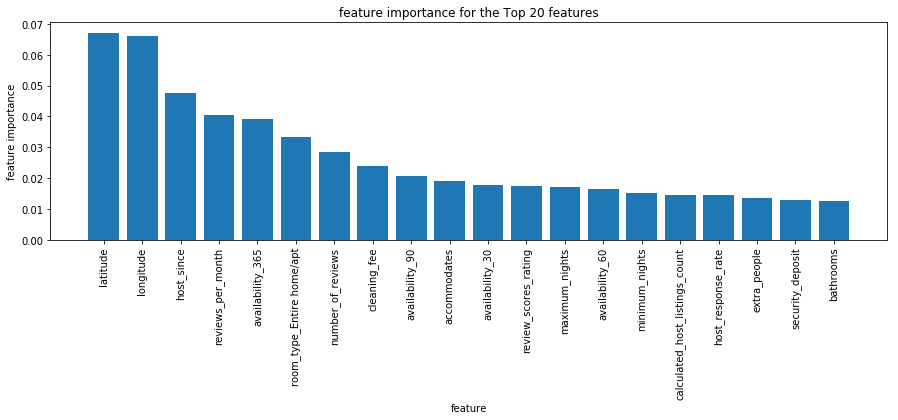

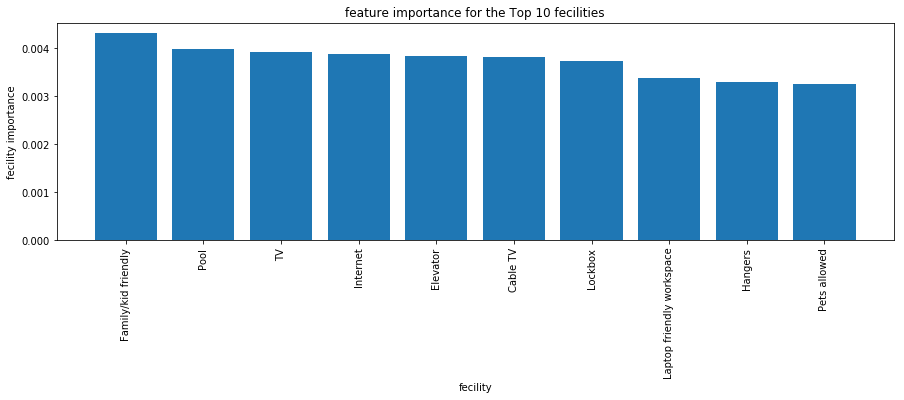

Training set has 6701 samples.
Testing set has 1676 samples.
{'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
50.418450352584586 {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
Error Score on Test Data: 45.66648645304016.


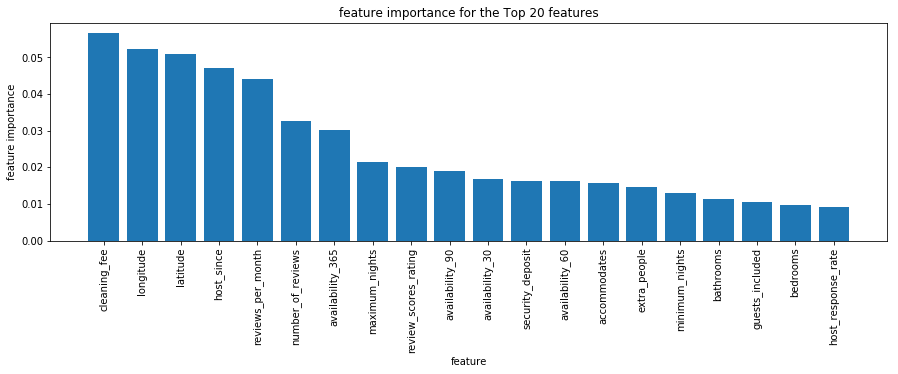

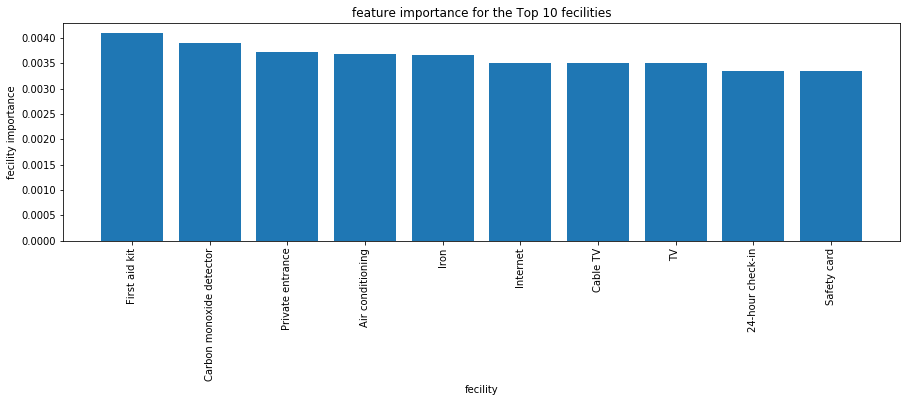

In [8]:
#training boston data
training(Boston, price_Boston, possible_fecilities_Boston)
#training seattle data
training(Seattle, price_Seattle, possible_fecilities_Seattle)

**Conclusion**:
#### lets recap what we did from the beginning

Gathered the Boston and Seattle Airbnb data  
- https://www.kaggle.com/airbnb/seattle/data#listings.csv
- https://www.kaggle.com/airbnb/boston#listings.csv

Did comparision of the two data sets Boston and Seattle.
Developed a machine learning model to predict the rental price for Boston and Seattle.
Examined feature importance of the trained model and check for usability of them.
Listed down important fecilities to get a clear understanind how service provider can make more money by providing better fecilities to customer by understanding the need.